# Movie  Analysis Project

## Introduction

This project aims to analyze movie data from various sources to provide data-driven insights for a company launching a new movie studio. The goal is to identify the types of films that are most likely to perform well at the box office. This analysis will help the company decide what kind of movies to create.

## Business Problem

Our company is venturing into the creation of original video content, specifically a new movie studio. However, the company lacks experience in the movie production industry. Therefore, this analysis will be a data-driven exploration into what types of films are currently achieving success at the box office and translating that into actionable recommendations for the new studio.

## Data Sources

The following datasets are used in this analysis:

*   `bom.movie_gross.csv`: Box office gross revenue data from Box Office Mojo.
*   `tn.movie_budgets.csv`: Movie budget data from The Numbers.
*   `tmdb.movies.csv`: Movie metadata (including genres, cast, and release date) from The Movie Database (TMDB).
*   `rt.movie_info.tsv`: Movie information and ratings from Rotten Tomatoes.
*   `rt.reviews.tsv`: Movie reviews from Rotten Tomatoes.
*  `im.db`: Movie information and ratings from the IMDB database

## Analysis Focus
This analysis will focus on addressing these key questions:

1.  **Financial Performance:**
    - Which genres are currently the most financially successful (highest revenue and profit)?
    - What is the average return on investment (ROI) for different genres?
    - Does a higher budget guarantee higher revenue?
    - What is the relationship between production budget and box office gross?
    - Are there budget levels that yield the best return for specific genres?
    - Which months are better for launching a movie? Do certain types of movies do better in specific months?

2.  **Popularity:**
    - Which genres are most popular among audiences (based on popularity metrics)?
    - What is the correlation between popularity and financial success?

3.  **Critical Acclaim & Audience Sentiment:**
    - Which genres tend to receive the highest critical ratings and positive reviews?
    - Is there a correlation between audience sentiment (from review text) and financial success?
    - How do ratings differ between Rotten Tomatoes, TMDB, or any other rating source?
    - Are there any inconsistencies across ratings?
    - Are there some movies that are more polarizing than others (have widely different reviews)?

4.  **Influence of Key Personnel:**
    - Which directors or actors are associated with high-grossing movies?
    - Are there some directors or actors that are strongly associated with one genre?
    - Are there any common collaborations between directors and actors in high-performing films?


The goal is to provide data-driven recommendations regarding which types of movies the new studio should prioritize, taking into consideration the financial performance, the popularity of those movies, and also taking into consideration the talent involved.

In [96]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import kruskal
import ast # For our genre

In [97]:
# Load the data
df_bom = pd.read_csv('Data/bom.movie_gross.csv')
df_tn = pd.read_csv('Data/tn.movie_budgets.csv')
df_tmdb = pd.read_csv('Data/tmdb.movies.csv')
df_rt_info = pd.read_table('Data/rt.movie_info.tsv')
df_rt_reviews = pd.read_table('Data/rt.reviews.tsv', encoding = 'latin-1')

In [98]:
conn = sqlite3.connect('Data/im.db')
cursor = conn.cursor()

## Getting General overview of our datasets

### The Box office Mojo (BOM) dataset

In [99]:
df_bom

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [100]:
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


For most columns they have relatively well populated except foreign_gross. The foreign_gross column is object type we will have to convert it into float64.

In [101]:
df_bom.describe()

,domestic_gross,year
count,3.359000e+03,3387.000000
mean,2.874585e+07,2013.958075
std,6.698250e+07,2.478141
min,1.000000e+02,2010.000000
25%,1.200000e+05,2012.000000
50%,1.400000e+06,2014.000000
75%,2.790000e+07,2016.000000
max,9.367000e+08,2018.000000


The numbers for the money movie are extremely huge for us to make meaning of the statistical measure. we might consider rounding them off to the nearest million.

In [102]:
df_bom['studio'].unique()

array(['BV', 'WB', 'P/DW', 'Sum.', 'Par.', 'Uni.', 'Fox', 'Wein.', 'Sony',
       'FoxS', 'SGem', 'WB (NL)', 'LGF', 'MBox', 'CL', 'W/Dim.', 'CBS',
       'Focus', 'MGM', 'Over.', 'Mira.', 'IFC', 'CJ', 'NM', 'SPC', 'ParV',
       'Gold.', 'JS', 'RAtt.', 'Magn.', 'Free', '3D', 'UTV', 'Rela.',
       'Zeit.', 'Anch.', 'PDA', 'Lorb.', 'App.', 'Drft.', 'Osci.', 'IW',
       'Rog.', nan, 'Eros', 'Relbig.', 'Viv.', 'Hann.', 'Strand', 'NGE',
       'Scre.', 'Kino', 'Abr.', 'CZ', 'ATO', 'First', 'GK', 'FInd.',
       'NFC', 'TFC', 'Pala.', 'Imag.', 'NAV', 'Arth.', 'CLS', 'Mont.',
       'Olive', 'CGld', 'FOAK', 'IVP', 'Yash', 'ICir', 'FM', 'Vita.',
       'WOW', 'Truly', 'Indic.', 'FD', 'Vari.', 'TriS', 'ORF', 'IM',
       'Elev.', 'Cohen', 'NeoC', 'Jan.', 'MNE', 'Trib.', 'Rocket',
       'OMNI/FSR', 'KKM', 'Argo.', 'SMod', 'Libre', 'FRun', 'WHE', 'P4',
       'KC', 'SD', 'AM', 'MPFT', 'Icar.', 'AGF', 'A23', 'Da.', 'NYer',
       'Rialto', 'DF', 'KL', 'ALP', 'LG/S', 'WGUSA', 'MPI', 'RTWC', 'FIP

In [103]:
df_bom['studio'].unique().size

258

Studio will have to given full name where it is abbreviate to make it easier to understand.

### The tn (The Numbers) dataset

In [104]:
df_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [105]:
df_tn['id'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

In [106]:
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


The dataset from the numbers doesn't have any null value that we can see so far. It has the issue of wrong data types for release_date, Production_Budget, Domestic_gross and Worldwide_gross columns and they will have to be convert to correct type.

In [107]:
df_tn.describe()

,id
count,5782.000000
mean,50.372363
std,28.821076
min,1.000000
25%,25.000000
50%,50.000000
75%,75.000000
max,100.000000


Describe function is result that much because the numeric columns are in object type but even the we have seen the number we are dealing with are extremely big so we are deciding to we go with the same route as the other dataset and then will inspect further.

### The tmdb (The Movie DB) dataset

In [108]:
df_tmdb

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [109]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


# Data Cleaning

### The imdb dataset

The dataset is an sqlite database, with data drom imdb.

In [110]:
# Getting the list of all the tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = [row[0] for row in cursor.fetchall()]
tables

['movie_basics',
 'directors',
 'known_for',
 'movie_akas',
 'movie_ratings',
 'persons',
 'principals',
 'writers']

In [111]:
for table in tables:
    print(f"Table: {table}")
    df = pd.read_sql(f"SELECT * FROM {table};", conn)
    df.info()
    print("\n" + "="*40 + "\n")

Table: movie_basics
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Table: directors
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Table: known_for
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data

In [112]:
# loading the movie_basics table
movie_basics = pd.read_sql("""SELECT *FROM movie_basics;""",conn)

# loading the movie_ratings table
movie_ratings = pd.read_sql("""SELECT *FROM movie_ratings;""",conn)

In [113]:
# Inner join merge movie_basics and movie_ratings
df_imdb = pd.merge(movie_basics, movie_ratings, on = ['movie_id'], how = 'inner')
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [114]:
# Rename column
df_imdb = df_imdb.rename(columns = {'primary_title':'title'})
df_imdb.head()

,movie_id,title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [115]:
df_imdb.dropna(inplace=True)

In [116]:
# Confirming if the null have now been dropped
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65720 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         65720 non-null  object 
 1   title            65720 non-null  object 
 2   original_title   65720 non-null  object 
 3   start_year       65720 non-null  int64  
 4   runtime_minutes  65720 non-null  float64
 5   genres           65720 non-null  object 
 6   averagerating    65720 non-null  float64
 7   numvotes         65720 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [117]:
# Get the top 30% of movies by rating
top_30_percent_threshold = int(len(df_imdb) * 0.3)
df_top_movies = df_imdb.iloc[:top_30_percent_threshold]

# Expand the genres column into individual genres
genre_counts = (
    df_top_movies['genres']
    .str.split(',')
    .explode()  # Splits and expands the genres into individual rows
    .value_counts()
)
genre_counts

genres
Drama          8968
Comedy         4969
Documentary    4414
Thriller       2480
Horror         2172
Action         2114
Romance        1879
Crime          1509
Adventure      1246
Biography      1179
Family          945
Mystery         899
History         859
Sci-Fi          717
Fantasy         676
Music           599
Animation       499
Sport           314
War             249
Musical         211
News            205
Western          86
Reality-TV        3
Game-Show         1
Name: count, dtype: int64

In [118]:
directors_table = pd.read_sql("""SELECT * FROM directors;""", conn)
directors_table

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
...,...,...
291169,tt8999974,nm10122357
291170,tt9001390,nm6711477
291171,tt9001494,nm10123242
291172,tt9001494,nm10123248


In [119]:
persons_table = pd.read_sql("""SELECT * FROM persons;""", conn)
persons_table

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"
...,...,...,...,...,...
606643,nm9990381,Susan Grobes,NaN,NaN,actress
606644,nm9990690,Joo Yeon So,NaN,NaN,actress
606645,nm9991320,Madeline Smith,NaN,NaN,actress
606646,nm9991786,Michelle Modigliani,NaN,NaN,producer


In [120]:
# Merge directors and persons table to get director details
directors_with_details = pd.merge(directors_table, persons_table, on='person_id', how='inner')

# Filter to only include alive directors (death_year is NaN)
alive_directors = directors_with_details[directors_with_details['death_year'].isna()]

# Merge with the movies data to associate directors with movies
alive_directors_movies = pd.merge(alive_directors, df_imdb, on='movie_id', how='inner')

# Count the number of movies per director
director_movie_counts = alive_directors_movies.groupby('primary_name').size().reset_index(name='movie_count')

# Sort by movie count in descending order
director_movie_counts = director_movie_counts.sort_values(by='movie_count', ascending=False)

top_6_directors = director_movie_counts.head(6)
top_6_directors

,primary_name,movie_count
43658,Shane Ryan,155
47953,Tony Newton,130
41360,Ruben Rodriguez,129
9523,Corey Norman,107
20890,Jason Impey,102
14680,Evan Marlowe,100


In [121]:
# Calculate the average ratings for each director
director_avg_ratings = (
    alive_directors_movies.groupby('primary_name')['averagerating']
    .mean()
    .reset_index(name='avg_rating')
)

# Merge the average ratings into the top_6_directors DataFrame
top_6_directors = pd.merge(top_6_directors, director_avg_ratings, on='primary_name', how='inner').style.hide(axis='index').data
top_6_directors

,primary_name,movie_count,avg_rating
0,Shane Ryan,155,5.626452
1,Tony Newton,130,4.785385
2,Ruben Rodriguez,129,6.079845
3,Corey Norman,107,6.017757
4,Jason Impey,102,5.158824
5,Evan Marlowe,100,6.403000


## The Box Office Mojo (BOM) dataset

We are going to begin our cleaning with the The Box Office Mojo. 

The following are the Action we are going to take:

**1. Fill the null values in foreign gross column with zero**
 - The rationale for this is we are going with the assumption that the movies that don't have foreign gross have not been sold internationally 

**2. Drop null values in domestic and studio.**
 - They are few as a result the deletion has no impact on our analysis.
 
**3. Feature Engineer: Create Worldwide gross.**
 - We will do this by adding domestic and foreign gross. 
 
**4. Feature Engineer: create studio names**
 - We will match studio name abbreation to their corresponding studio names.
 
**5. We round off our currency columns to the nearest million**
 - This is to make our data more readable and easier to work with.
 
**6. We are going to filter our dataset.**
   - We will use worldwide gross to remove movies that made less than a million
   
**7. Standadization.**
   - Title column in title format

In [122]:
# Before cleaning
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [123]:
# Fill null columns in the foreign_gross column, with 0
df_bom['foreign_gross'].fillna(0, inplace=True)

In [124]:
# Drop null records in domestic_gross and studio columns
df_bom.dropna(subset=['domestic_gross', 'studio'], inplace=True)

In [125]:
# Remove commas, and change the datatype of the column to be float
df_bom['foreign_gross'] = df_bom['foreign_gross'].replace(',', '', regex=True).astype(float)

In [126]:
# Feature engineer a worlswide_gross column
df_bom['worldwide_gross'] = df_bom['domestic_gross'] + df_bom['foreign_gross']

Sony Pictures refers to the broader production arm responsible for mainstream movies.
Sony Pictures Classics (SPC) is a subsidiary that specializes in independent films, documentaries, and arthouse productions.
Therefore here, we will combine Sony with SPC.

In [127]:
studio_map = {
    'BV': 'Buena Vista',
    'WB': 'Warner Bros.',
    'P/DW': 'Paramount/DreamWorks',
    'Sum.': 'Summit Entertainment',
    'Par.': 'Paramount Pictures',
    'Uni.': 'Universal Pictures',
    'Fox': '20th Century Fox',
    'Wein.': 'The Weinstein Company',
    'Sony': 'Sony Pictures',
    'FoxS': 'Fox Searchlight Pictures',
    'SGem': 'Screen Gems',
    'WB (NL)': 'Warner Bros. (New Line Cinema)',
    'LGF': 'Lionsgate Films',
    'MBox': 'Movie Box',
    'CL': 'Columbia Pictures',
    'W/Dim.': 'Walt Disney/Dimension Films',
    'CBS': 'CBS Films',
    'Focus': 'Focus Features',
    'MGM': 'Metro-Goldwyn-Mayer',
    'Over.': 'Overture Films',
    'Mira.': 'Miramax Films',
    'IFC': 'IFC Films',
    'CJ': 'CJ Entertainment',
    'NM': 'Newmarket Films',
    'SPC': 'Sony Pictures',  # Combine Sony Pictures, with Sony Pictures classic
    'ParV': 'Paramount Vantage',
    'Gold.': 'Goldwyn Films',
    'JS': 'Jerry Seinfeld Productions',
    'RAtt.': 'Roadside Attractions',
    'Magn.': 'Magnolia Pictures',
    'Free': 'Freestyle Releasing',
    '3D': '3D Entertainment',
    'UTV': 'UTV Motion Pictures',
    'Rela.': 'Relativity Media',
    'Zeit.': 'Zeitgeist Films',
    'Anch.': 'Anchor Bay Entertainment',
    'PDA': 'Picturehouse',
    'Lorb.': 'Lorber Films',
    'App.': 'Apparition',
    'Drft.': 'DraftHouse Films',
    'Osci.': 'Oscilloscope Laboratories',
    'IW': 'IndieWire Films',
    'Rog.': 'Rogue Pictures',
    'Eros': 'Eros International',
    'Relbig.': 'Reliance Big Entertainment',
    'Viv.': 'Vivendi Entertainment',
    'Hann.': 'Hannover House',
    'Strand': 'Strand Releasing',
    'NGE': 'Next Generation Entertainment',
    'Scre.': 'Screen Media Films',
    'Kino': 'Kino Lorber',
    'Abr.': 'Abramorama',
    'CZ': 'Czech Films',
    'ATO': 'ATO Pictures',
    'First': 'First Look Pictures',
    'GK': 'GK Films',
    'FInd.': 'Film Independent',
    'NFC': 'National Film Corporation',
    'TFC': 'The Film Collaborative',
    'Pala.': 'Paladin Films',
    'Imag.': 'Imagine Entertainment',
    'NAV': 'Navarre Corporation',
    'Arth.': 'Art House Films',
    'CLS': 'Classic Films',
    'Mont.': 'Montreal Films',
    'Olive': 'Olive Films',
    'CGld': 'Cineguild',
    'FOAK': 'Film on Air Kids',
    'IVP': 'Independent Video Producers',
    'Yash': 'Yash Raj Films',
    'ICir': 'International Circuit',
    'FM': 'Film Movement',
    'Vita.': 'Vitascope',
    'WOW': 'World of Wonder',
    'Truly': 'Truly Indie',
}

In [128]:
df_bom['studio_name'] = df_bom['studio'].map(studio_map).fillna('Unknown')

In [129]:
df_bom[['domestic_gross', 'foreign_gross', 'worldwide_gross']] /= 1_000_000

In [130]:
df_bom = df_bom[df_bom['worldwide_gross'] >= 1]

In [131]:
df_bom['title'] = df_bom['title'].str.title()

C:\Users\HP\AppData\Local\Temp\ipykernel_3344\2858481086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom['title'] = df_bom['title'].str.title()


In [132]:
# After cleaning 
df_bom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2185 entries, 0 to 3284
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            2185 non-null   object 
 1   studio           2185 non-null   object 
 2   domestic_gross   2185 non-null   float64
 3   foreign_gross    2185 non-null   float64
 4   year             2185 non-null   int64  
 5   worldwide_gross  2185 non-null   float64
 6   studio_name      2185 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 136.6+ KB


## Cleaning the numbers dataset

**1. Standadization**
 - Remove dollar sign in production_budget, domestic_gross and worldwide_gross columns
 - Rename movie column Title and as title format

**2. Conver colums into appropiate data types.**
 -  production_budget, domestic_gross and worldwide_gross columns to interger
 - release_data to datetime data type

**3. Round of our courrency collumns to the nearest millon**

**4. Feature Engineer**
 - Create Profit column by substructing production budget from worldwide_gross. we are operating on the assumption that the production budget was the actual cost and close enough.

**5. Drop id Column**

In [133]:
# Before cleaning
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [134]:
for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    df_tn[col] = df_tn[col].replace('[\$,]', '', regex=True).astype(float)

In [135]:
df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])

In [136]:
df_tn[['production_budget', 'domestic_gross', 'worldwide_gross']] /= 1_000_000

In [137]:
df_tn['profit'] = df_tn['worldwide_gross'] - df_tn['production_budget']

In [138]:
df_tn.rename(columns={'movie': 'title'}, inplace=True)
df_tn['title'] = df_tn['title'].str.title()

In [139]:
df_tn.drop(columns=['id'], inplace=True)

In [140]:
# After cleaning
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       5782 non-null   datetime64[ns]
 1   title              5782 non-null   object        
 2   production_budget  5782 non-null   float64       
 3   domestic_gross     5782 non-null   float64       
 4   worldwide_gross    5782 non-null   float64       
 5   profit             5782 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 271.2+ KB


## Cleaning the tmdb dataset

**1. Drop 'unnamed' and 'id' columns**

**2. Match abbreviations with actual names**
 - column genre_id to their corresponding genre names for easy readability.
 - column original_language to their full languag

**3. convert release_date to datetime datatypes**

**4. Deal with outliers**

**5. subsetting for data relevant for the analysis.**
 - By using the vote_count column, we only select record where it is above 100

In [141]:
# Before cleaning
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [142]:
# Genre mapping dictionary
genre_mapping = {
    28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime", 99: "Documentary", 
    18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music", 
    9648: "Mystery", 10749: "Romance", 878: "Science Fiction", 10770: "TV Movie", 53: "Thriller", 
    10752: "War", 37: "Western"
}

# Function to map genre IDs to names
def map_genres(ids):
    ids_list = ast.literal_eval(ids)  # Convert string representation of list to actual list
    return ", ".join([genre_mapping.get(id, "Unknown") for id in ids_list])

# Create the new column with genres
df_tmdb['genres'] = df_tmdb['genre_ids'].apply(map_genres)
df_tmdb

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,genres
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure, Fantasy, Family"
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Fantasy, Adventure, Animation, Family"
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Adventure, Action, Science Fiction"
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,"Animation, Comedy, Family"
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,"Action, Science Fiction, Adventure"
...,...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1,"Horror, Drama"
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1,"Drama, Thriller"
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1,"Fantasy, Action, Adventure"
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1,"Family, Adventure, Action"


In [143]:
# Drop the unnecessary columns
df_tmdb = df_tmdb.drop(columns=['Unnamed: 0', 'genre_ids', 'original_language', 'original_title'])

# Convert release_date to datetime format
df_tmdb['release_date'] = pd.to_datetime(df_tmdb['release_date'], errors='coerce')

In [144]:
language_map = {
    'en': 'English',
    'fr': 'French',
    'es': 'Spanish',
    'ru': 'Russian',
    'ja': 'Japanese',
    'de': 'German',
    'zh': 'Chinese',
    'ko': 'Korean',
    'hi': 'Hindi',
    'it': 'Italian',
    'pt': 'Portuguese',
    'ar': 'Arabic',
    'tr': 'Turkish',
    'nl': 'Dutch',
    'sv': 'Swedish',
    'da': 'Danish',
    'no': 'Norwegian',
    'fi': 'Finnish',
    'pl': 'Polish',
    'el': 'Greek'
}

Checking for outliers

<Axes: >

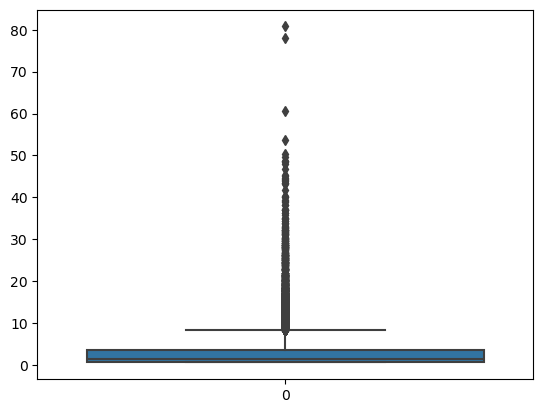

In [145]:
# Check the boxplot
sns.boxplot(df_tmdb['popularity'])

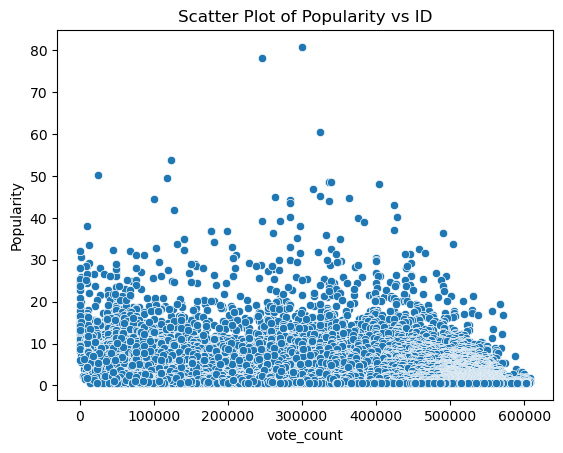

In [146]:
# Create a scatter plot of popularity column

sns.scatterplot(x=df_tmdb['id'], y=df_tmdb['popularity'])
plt.title('Scatter Plot of Popularity vs ID')
plt.xlabel('vote_count')
plt.ylabel('Popularity')
plt.show()

In [147]:
popularity_threshold = df_tmdb['popularity'].quantile(0.995)
df_tmdb = df_tmdb[df_tmdb['popularity'] <= popularity_threshold]

In [148]:
df_tmdb = df_tmdb[df_tmdb['vote_count'] > 100]

In [149]:
# Determine the 70th percentile of popularity
popularity_threshold = df_tmdb['popularity'].quantile(0.7)

# Filter to get the top 30% most popular movies
top_30_percent = df_tmdb[df_tmdb['popularity'] >= popularity_threshold]

# Expand the genres column to separate entries and clean spaces
expanded_genres = top_30_percent['genres'].str.split(',').explode().str.strip()

# Count the occurrences of each genre
genre_counts = expanded_genres.value_counts()
top_10_genres =  genre_counts.head(10)
top_10_genres

genres
Drama              439
Action             352
Thriller           348
Comedy             300
Adventure          231
Crime              170
Science Fiction    161
Horror             140
Fantasy            136
Family             129
Name: count, dtype: int64

In [150]:
# After cleaning
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3536 entries, 7 to 24546
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3536 non-null   int64         
 1   popularity    3536 non-null   float64       
 2   release_date  3536 non-null   datetime64[ns]
 3   title         3536 non-null   object        
 4   vote_average  3536 non-null   float64       
 5   vote_count    3536 non-null   int64         
 6   genres        3536 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 221.0+ KB


In [151]:
###

In [152]:
# Selecting those with higher vote count of at least 100
df_tmdb_filtered = df_tmdb[df_tmdb['vote_count'] > 100]
df_tmdb_filtered.shape

(3536, 7)

In [154]:
#df_tmdb['original_language'].value_counts()

We can observe id column. These are ids given to the movies might come in handy if other dataset label movies with the same kind of ids.

In [155]:
df_tmdb

,id,popularity,release_date,title,vote_average,vote_count,genres
7,10193,24.445,2010-06-17,Toy Story 3,7.7,8340,"Animation, Family, Comedy"
8,20352,23.673,2010-07-09,Despicable Me,7.2,10057,"Animation, Family, Comedy"
9,38055,22.855,2010-11-04,Megamind,6.8,3635,"Animation, Action, Comedy, Family, Science Fic..."
10,863,22.698,1999-11-24,Toy Story 2,7.5,7553,"Animation, Comedy, Family"
11,12155,22.020,2010-03-05,Alice in Wonderland,6.6,8713,"Family, Fantasy, Adventure"
...,...,...,...,...,...,...,...
24462,503314,6.868,2019-01-16,Dragon Ball Super: Broly,7.4,721,"Action, Animation, Fantasy, Adventure, Comedy,..."
24469,416186,6.823,2018-04-20,Godard Mon Amour,6.8,160,"Drama, Romance, Comedy"
24472,531949,6.794,2018-07-20,Father of the Year,5.3,235,Comedy
24505,489430,6.553,2018-09-21,Terrified,6.4,111,Horror


In [156]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3536 entries, 7 to 24546
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            3536 non-null   int64         
 1   popularity    3536 non-null   float64       
 2   release_date  3536 non-null   datetime64[ns]
 3   title         3536 non-null   object        
 4   vote_average  3536 non-null   float64       
 5   vote_count    3536 non-null   int64         
 6   genres        3536 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 221.0+ KB


In [157]:
df_bom

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross,studio_name
0,Toy Story 3,BV,415.0,652.0,2010,1067.0,Buena Vista
1,Alice In Wonderland (2010),BV,334.2,691.3,2010,1025.5,Buena Vista
2,Harry Potter And The Deathly Hallows Part 1,WB,296.0,664.3,2010,960.3,Warner Bros.
3,Inception,WB,292.6,535.7,2010,828.3,Warner Bros.
4,Shrek Forever After,P/DW,238.7,513.9,2010,752.6,Paramount/DreamWorks
...,...,...,...,...,...,...,...
3280,Andhadhun,Eros,1.2,0.0,2018,1.2,Eros International
3281,Lean On Pete,A24,1.2,0.0,2018,1.2,Unknown
3282,Nothing To Lose (2018),Swen,1.0,0.0,2018,1.0,Unknown
3283,Raid (2018),Eros,1.0,0.0,2018,1.0,Eros International


Sony Pictures refers to the broader production arm responsible for mainstream movies.  
Sony Pictures Classics (SPC) is a subsidiary that specializes in independent films, documentaries, and arthouse productions.

In [158]:
# Mapping popular studios and combining SPC with Sony
popular_studios_mapping = {
    'Uni.': 'Universal Pictures',
    'WB': 'Warner Bros.',
    'Fox': '20th Century Fox',
    'BV': 'Buena Vista',
    'Sony': 'Sony Pictures',
    'LGF': 'Lionsgate Films',
    'Par.': 'Paramount Pictures',
    'SPC': 'Sony Pictures'  # Grouping SPC with Sony Pictures
}

# Replace studio abbreviations and group others as 'Other'
df_bom['studio'] = df_bom['studio'].replace(popular_studios_mapping)
df_bom['studio'] = df_bom['studio'].apply(lambda x: x if x in popular_studios_mapping.values() else 'Other')

# Verify the final grouping
print(df_bom['studio'].value_counts())

studio
Other                 1263
Sony Pictures          202
Universal Pictures     145
Warner Bros.           136
20th Century Fox       136
Buena Vista            105
Paramount Pictures      99
Lionsgate Films         99
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_3344\2748755552.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom['studio'] = df_bom['studio'].replace(popular_studios_mapping)
C:\Users\HP\AppData\Local\Temp\ipykernel_3344\2748755552.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom['studio'] = df_bom['studio'].apply(lambda x: x if x in popular_studios_mapping.values() else 'Other')


In [159]:
df_bom.head(10)

,title,studio,domestic_gross,foreign_gross,year,worldwide_gross,studio_name
0,Toy Story 3,Buena Vista,415.0,652.0,2010,1067.0,Buena Vista
1,Alice In Wonderland (2010),Buena Vista,334.2,691.3,2010,1025.5,Buena Vista
2,Harry Potter And The Deathly Hallows Part 1,Warner Bros.,296.0,664.3,2010,960.3,Warner Bros.
3,Inception,Warner Bros.,292.6,535.7,2010,828.3,Warner Bros.
4,Shrek Forever After,Other,238.7,513.9,2010,752.6,Paramount/DreamWorks
5,The Twilight Saga: Eclipse,Other,300.5,398.0,2010,698.5,Summit Entertainment
6,Iron Man 2,Paramount Pictures,312.4,311.5,2010,623.9,Paramount Pictures
7,Tangled,Buena Vista,200.8,391.0,2010,591.8,Buena Vista
8,Despicable Me,Universal Pictures,251.5,291.6,2010,543.1,Universal Pictures
9,How To Train Your Dragon,Other,217.6,277.3,2010,494.9,Paramount/DreamWorks


In [160]:
# Create a DataFrame with top studios only
df_bom_top_studios = df_bom[df_bom['studio'] != 'Other']

### Testing the relationship between the studio and worldwide gross (for BOM)
We could perform a statistical test here, for testing the relationship between the studio and worldwide gross. 


Null Hypothesis: The studio a movie is produced by has no impact on the worldwide gross.  

Alternative Hypothesis: The studio a movie is produced by does have an impact on the worldwide gross.

We could perform an ANOVA test, but it has the assumption of the data following a normal distribution.  
We can see first whether the data is normally distributed, if not, we use another alternative that doesn't have that assumption, e.g. the Kruskal-Wallis test.

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


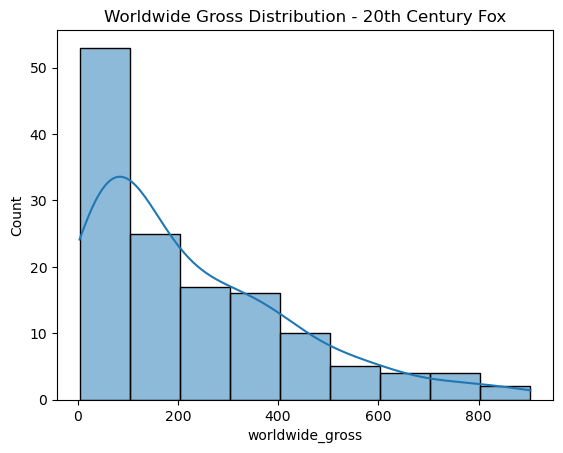

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


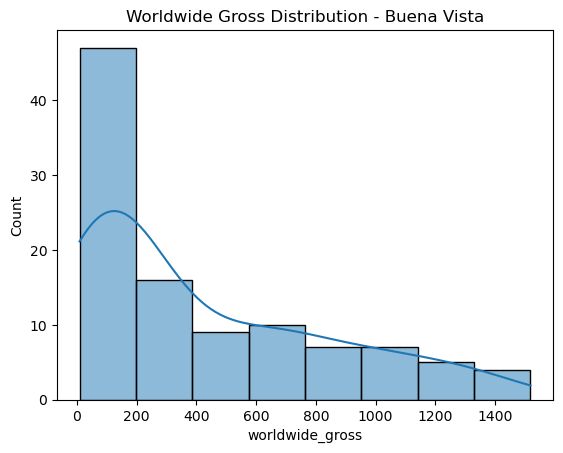

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


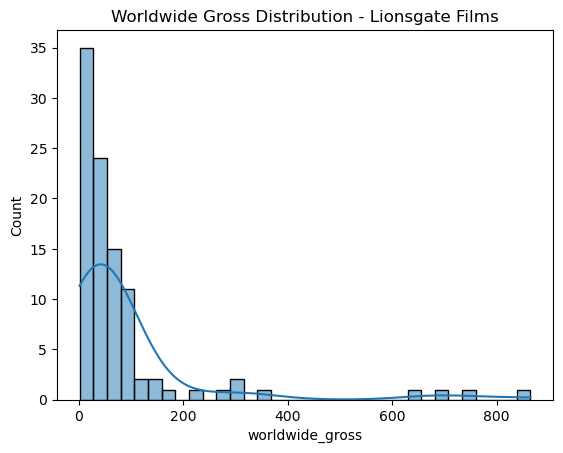

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


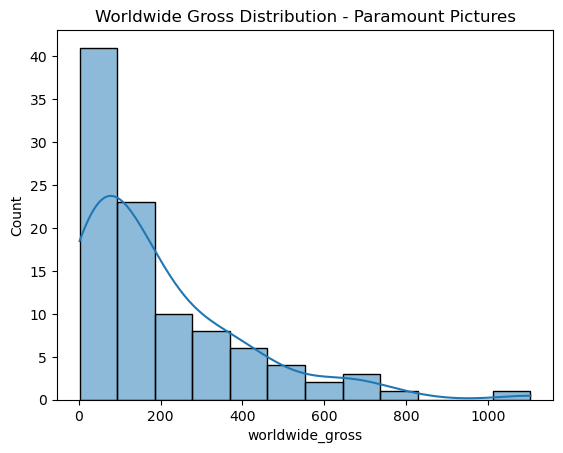

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


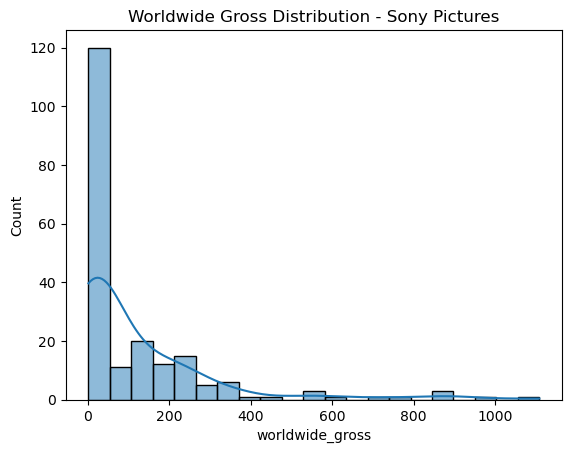

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


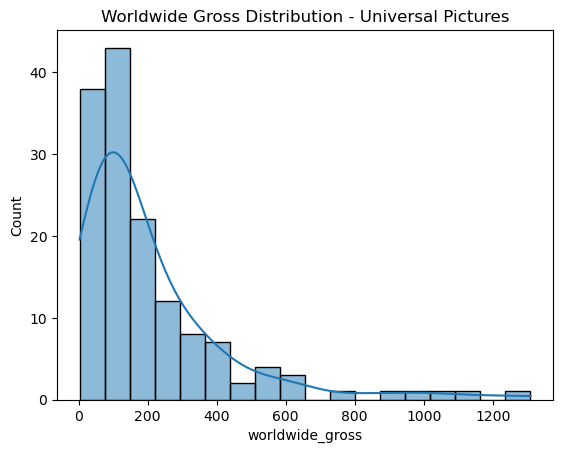

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


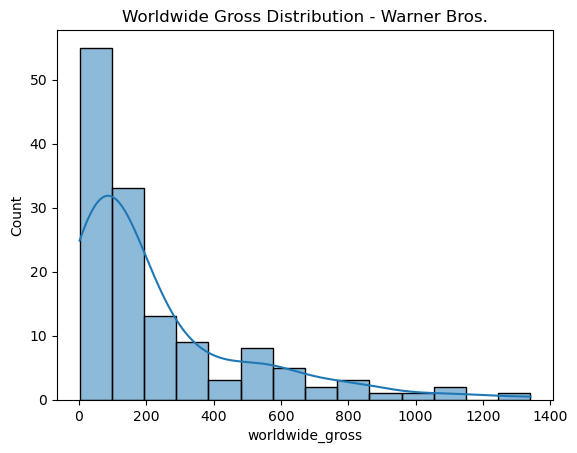

In [161]:
for studio, group in df_bom_top_studios.groupby('studio'):
    sns.histplot(group['worldwide_gross'], kde=True)
    plt.title(f"Worldwide Gross Distribution - {studio}")
    plt.show()

Since from the above we can clearly see the data isn't normally distributed, we can use the Kruskal-Wallis test as the alternative.

In [162]:
# Group data by studios
groups = [group['worldwide_gross'] for name, group in df_bom_top_studios.groupby('studio')]

# Perform Kruskal-Wallis Test
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis H test statistic: {stat:.4f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject null hypothesis: Significant difference in worldwide gross among studios.")
else:
    print("Fail to reject null hypothesis: No significant difference in worldwide gross among studios.")


Kruskal-Wallis H test statistic: 149.8354, p-value: 0.0000
Reject null hypothesis: Significant difference in worldwide gross among studios.


In [163]:
h_stat = stat  # From Kruskal-Wallis
n_total = len(df_bom_top_studios)  # Total number of observations
epsilon_squared = (h_stat - len(groups) + 1) / (n_total - len(groups))

print(f"Epsilon Squared (Effect Size): {epsilon_squared:.4f}")
if epsilon_squared < 0.01:
    print("Effect size: Negligible")
elif epsilon_squared < 0.06:
    print("Effect size: Small")
elif epsilon_squared < 0.14:
    print("Effect size: Medium")
else:
    print("Effect size: Large")

Epsilon Squared (Effect Size): 0.1572
Effect size: Large


In [164]:
# Summary statistics for each studio
df_bom_top_studios.groupby('studio')['worldwide_gross'].describe()

,count,mean,std,min,25%,50%,75%,max
studio,,,,,,,,
20th Century Fox,136.0,227.980637,205.978523,3.933,68.175,158.5,349.425000,903.6
Buena Vista,105.0,421.074276,412.791565,8.600,80.400,216.6,678.801369,1518.9
Lionsgate Films,99.0,86.797684,151.093721,1.400,17.600,47.3,78.750000,865.0
Paramount Pictures,99.0,197.456542,205.529561,2.206,46.700,133.5,277.450000,1104.0
Sony Pictures,202.0,117.782966,189.751432,1.000,5.600,31.0,160.475000,1108.6
Universal Pictures,145.0,205.215925,224.940846,2.349,72.800,127.9,270.700000,1309.5
Warner Bros.,136.0,226.718404,264.363460,1.800,51.400,122.3,299.600000,1341.5


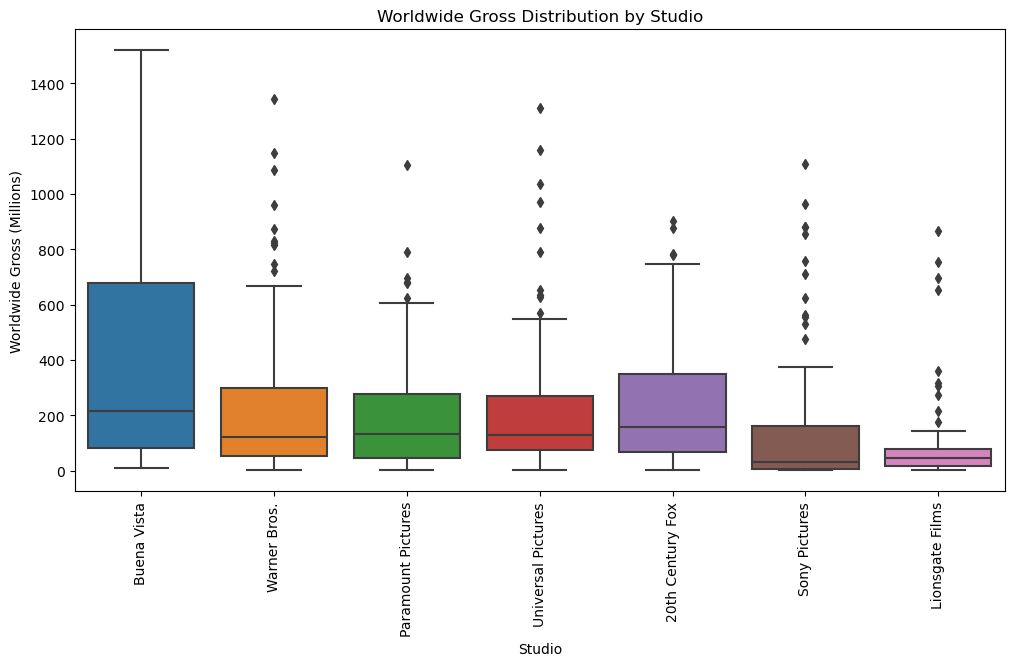

In [165]:
# Boxplot for worldwide_gross to check outliers visually
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_bom_top_studios, x='studio', y='worldwide_gross')
plt.title('Worldwide Gross Distribution by Studio')
plt.xlabel('Studio')
plt.ylabel('Worldwide Gross (Millions)')
plt.xticks(rotation=90)
plt.show()

In [166]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for 'worldwide_gross' for each studio
Q1 = df_bom_top_studios.groupby('studio')['worldwide_gross'].quantile(0.25)
Q3 = df_bom_top_studios.groupby('studio')['worldwide_gross'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Determine the lower and upper bounds for each studio's 'worldwide_gross'
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Map the lower and upper bounds to match each studio in the dataframe
df_bom_top_studios['lower_bound'] = df_bom_top_studios['studio'].map(lower_bound)
df_bom_top_studios['upper_bound'] = df_bom_top_studios['studio'].map(upper_bound)

# Create a mask to filter the rows that do not have outliers
mask = (df_bom_top_studios['worldwide_gross'] >= df_bom_top_studios['lower_bound']) & \
       (df_bom_top_studios['worldwide_gross'] <= df_bom_top_studios['upper_bound'])

# Apply the mask to remove the outliers
df_bom_top_studios_no_outliers = df_bom_top_studios[mask]

# Check the number of records before and after outlier removal
print(f"Before: {len(df_bom_top_studios)} records")
print(f"After: {len(df_bom_top_studios_no_outliers)} records")

# Optional: Summary statistics for the cleaned data
df_bom_top_studios_no_outliers.groupby('studio')['worldwide_gross'].describe()

Before: 922 records
After: 870 records


C:\Users\HP\AppData\Local\Temp\ipykernel_3344\187844202.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom_top_studios['lower_bound'] = df_bom_top_studios['studio'].map(lower_bound)
C:\Users\HP\AppData\Local\Temp\ipykernel_3344\187844202.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bom_top_studios['upper_bound'] = df_bom_top_studios['studio'].map(upper_bound)


,count,mean,std,min,25%,50%,75%,max
studio,,,,,,,,
20th Century Fox,132.0,209.564141,178.910363,3.933,67.425,151.95,330.550000,747.800000
Buena Vista,105.0,421.074276,412.791565,8.600,80.400,216.60,678.801369,1518.900000
Lionsgate Films,89.0,44.696233,34.011192,1.400,16.364,45.20,66.900000,142.400000
Paramount Pictures,93.0,161.013954,145.474527,2.206,41.800,119.50,244.800000,605.499999
Sony Pictures,190.0,78.388206,98.671824,1.000,4.703,26.65,132.750000,375.500000
Universal Pictures,135.0,156.548209,124.516559,2.349,68.250,115.30,214.350000,549.400000
Warner Bros.,126.0,170.565897,171.469927,1.800,47.800,106.65,225.875000,668.000000
